In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import statsmodels.formula.api as smf
import datetime as dt

from Package.PlotHandler import *

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 설정
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
raw_data_df = pd.read_excel('Data/데이터 취합(240528).xlsx')

In [5]:
tidy_data = raw_data_df.dropna()
tidy_data.set_index('date', inplace=True)

In [6]:
# KOSPI 가격 수준 지표
kospi_rolling_window = 125

kospi_index_df = tidy_data[['코스피 지수']].copy()
kospi_index_df['코스피 125MA'] = kospi_index_df.rolling(window=125).mean()
kospi_index_df['kospi_deviation'] = kospi_index_df['코스피 지수'] - kospi_index_df['코스피 125MA']

In [7]:
# 신고저가 종목 Net 52 high_low(구성종목수 추가)
krx_highlow_window = 125

krx_52highlow_df = tidy_data[['KRX 신고가 종목', 'KRX 신저가 종목', '코스피 거래종목 수 ', '코스닥 거래종목 수']].copy()
krx_52highlow_5days_df = krx_52highlow_df.rolling(window=50).sum()
krx_52highlow_5days_df['net_high_low_ratio'] = (
    (krx_52highlow_5days_df.iloc[:,0] - krx_52highlow_5days_df.iloc[:,1])/
        (krx_52highlow_5days_df.iloc[:,2]+krx_52highlow_5days_df.iloc[:,3])
    )

In [8]:
# Put, Call ratio 5일 계산
put_call_ratio_window = 5
put_call_ratio_df = tidy_data[['거래량 Put', '거래량 Call']].copy()
put_call_ratio_df['put/call ratio'] = put_call_ratio_df['거래량 Put']/ put_call_ratio_df['거래량 Call']
put_call_5d_sum = put_call_ratio_df.rolling(window=put_call_ratio_window).mean()

In [9]:
# VKOSPI 50일 이동 평균 Deviation
vkospi_window = 50
vkospi_df = tidy_data[['VKOSPI']].copy()
vkospi_df['50ma'] = vkospi_df.rolling(window=vkospi_window).mean()
vkospi_df['vkospi_deviance'] = vkospi_df['VKOSPI'] - vkospi_df['50ma']

In [10]:
# 회사채 Spread(Junk bond Spread)
junk_bond_spread_df = tidy_data[['국고채권(3년)','회사채(무보증3년)AA-', '회사채(무보증3년)BBB-']].copy()
junk_bond_spread_df['junkbond_spread'] = -junk_bond_spread_df['회사채(무보증3년)AA-']  +junk_bond_spread_df['회사채(무보증3년)BBB-']
junk_bond_spread_df['credit_spread'] = -junk_bond_spread_df['국고채권(3년)']  +junk_bond_spread_df['회사채(무보증3년)AA-']

In [11]:
# 채권, 주식 수익률(1개월, 3개월,6개월, 12개월 각각 계산 등, CNN에서는 20일 수익률 사용)
safe_haven_window = 20
safe_haven_demand_df = tidy_data[['코스피 지수', '국고채권(10년)']].copy()
safe_haven_demand_df['코스피 20일 수익률'] = safe_haven_demand_df['코스피 지수'].pct_change(periods=safe_haven_window)
safe_haven_demand_df['채권 20일 수익률'] = np.nan
for i in range(20, len(safe_haven_demand_df)):
    r_t_1 = safe_haven_demand_df.iloc[i- safe_haven_window + 1,1]
    r_t = safe_haven_demand_df.iloc[i,1]
    bond_return = r_t_1/r_t + r_t_1/1200 + ((1+r_t/1200)**(-119) * (1- r_t_1/r_t))
    safe_haven_demand_df.iloc[i, 3] = bond_return-1
safe_haven_demand_df['safe_haven_return'] = safe_haven_demand_df['코스피 20일 수익률'] - safe_haven_demand_df['채권 20일 수익률']


In [12]:
# 상승, 하락 종목수 Sentiment
mcclellan_df = tidy_data[['코스피 상승종목수', '코스피 하락종목수']].copy()
mcclellan_df['net advance'] = mcclellan_df['코스피 상승종목수'] - mcclellan_df['코스피 하락종목수']
mcclellan_df['ratio_adjusted'] = mcclellan_df['net advance']/(mcclellan_df['코스피 상승종목수'] + mcclellan_df['코스피 하락종목수'])*1000

# 19일 EMA 계산
mcclellan_df['19_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=50, adjust=False).mean()

# 39일 EMA 계산
mcclellan_df['39_day_EMA'] = mcclellan_df['ratio_adjusted'].ewm(span=125, adjust=False).mean()

# 19일 EMA와 39일 EMA의 차이 계산
mcclellan_df['EMA_diff'] = mcclellan_df['19_day_EMA'] - mcclellan_df['39_day_EMA']

In [13]:
data_name_list = ['PC_ratio', 'KOSPI_dev', 'VKOSPI_dev', 'junkbond_spread', 'credit_spread', 'safe_haven_return', 'EMA_diff',
                  'USD/KRW', 'KR_CDS_spread']
whole_data_df = pd.DataFrame([
        put_call_5d_sum['put/call ratio'],
        kospi_index_df['kospi_deviation'],
        vkospi_df['vkospi_deviance'],
        junk_bond_spread_df['junkbond_spread'],
        junk_bond_spread_df['credit_spread'],
        safe_haven_demand_df['safe_haven_return'],
        mcclellan_df['EMA_diff'],
        tidy_data['원/달러(종가)'],
        tidy_data['한국 CDS Spread'],
    ], index = data_name_list)

whole_data_df = whole_data_df.T

In [14]:
def rolling_standardize(series, window):
    """주어진 시리즈에 대해 윈도우 크기를 사용하여 표준화합니다."""
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std()
    standardized_series = (series - rolling_mean) / rolling_std
    return standardized_series

# 각 열에 대한 윈도우 크기를 정의합니다
window_sizes = {
    'PC_ratio': 504,
    'KOSPI_dev': 125,
    'VKOSPI_dev': 50,
    'junkbond_spread': 50,
    'credit_spread': 50,
    'safe_haven_return': 50,
    'EMA_diff': 504,
    'USD/KRW': 50,
    'KR_CDS_spread': 50
}

minus_sign = {
    'PC_ratio': True,
    'KOSPI_dev': False,
    'VKOSPI_dev': True,
    'junkbond_spread': True,
    'credit_spread': True,
    'safe_haven_return': False,
    'EMA_diff': False,
    'USD/KRW': True,
    'KR_CDS_spread': True
}

# 각 열에 대해 표준화를 수행합니다
standardized_df = pd.DataFrame(index=whole_data_df.index)

for column, window in window_sizes.items():
    if minus_sign[column]:
        standardized_df[column] = rolling_standardize(-whole_data_df[column], window)
    else:
        standardized_df[column] = rolling_standardize(whole_data_df[column], window)

# FIXME: 
mean_values = standardized_df.T.mean().T * 50 + 50

def normalize_series(series, window=125):
    rolling_min = series.rolling(window=window, min_periods=1).min()
    rolling_max = series.rolling(window=window, min_periods=1).max()
    normalized_series = (series - rolling_min) / (rolling_max - rolling_min)
    return normalized_series

# 그냥 지수
normalized_mean_values = mean_values
# 100으로 변환 되도록 바꿈
normalized_mean_values = normalize_series(mean_values) *100

<Axes: >

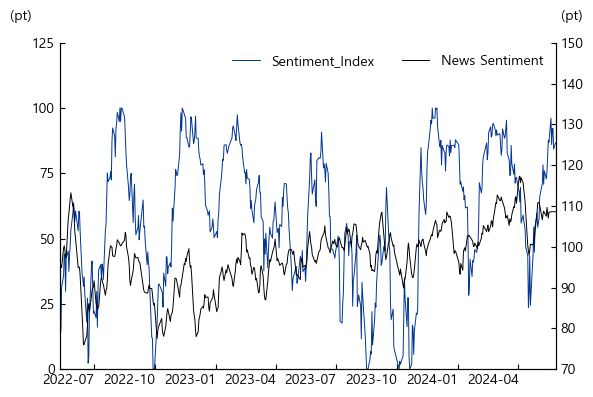

In [15]:
last_plot_n = 504
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], tidy_data['뉴스심리지수(일간)'][-last_plot_n:]], index=['Sentiment_Index', 'News Sentiment']).T
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

<Axes: >

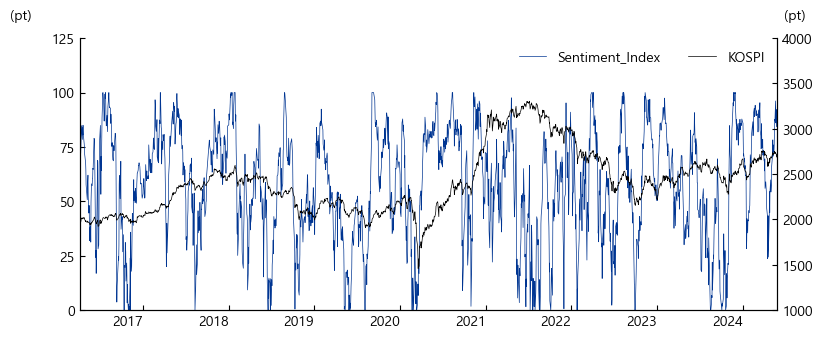

In [16]:
last_plot_n = 2000
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], kospi_index_df['코스피 지수'][-last_plot_n:]], index=['Sentiment_Index', 'KOSPI']).T
plt.figure(figsize=(9,4))
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.5)

<Axes: >

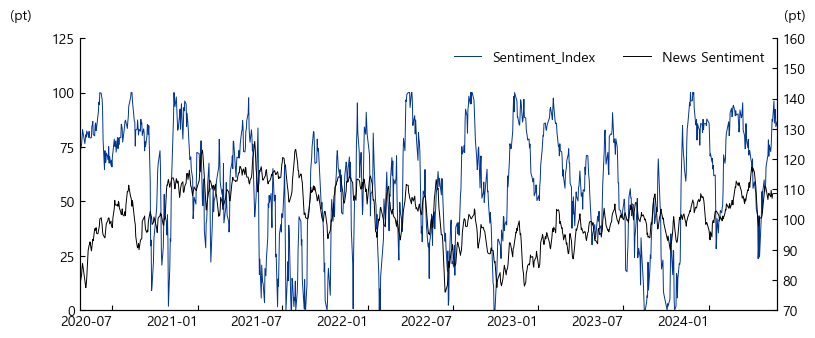

In [17]:
last_plot_n = 1008
plot_data_df = pd.DataFrame([normalized_mean_values[-last_plot_n:], tidy_data['뉴스심리지수(일간)'][-last_plot_n:]], index=['Sentiment_Index', 'News Sentiment']).T
plt.figure(figsize=(9,4))
plot_multi(data=plot_data_df, unit_list=['(pt)', '(pt)'], colors=IBK_COLOR_LIST, linewidth=0.7)

## 1개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [18]:
### 1개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = -22
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     183.6
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           8.09e-41
Time:                        14:51:16   Log-Likelihood:                -9807.0
No. Observations:                3551   AIC:                         1.962e+04
Df Residuals:                    3549   BIC:                         1.963e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.5473      0.629    -10.408      0.0

## 1개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [19]:
### 1개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = 0
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.4235
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.515
Time:                        14:51:16   Log-Likelihood:                -10609.
No. Observations:                3529   AIC:                         2.122e+04
Df Residuals:                    3527   BIC:                         2.124e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8004      0.703      1.139      0.2

## 3개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [20]:
### 3개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 66
lag = -66
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     35.13
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           3.37e-09
Time:                        14:51:16   Log-Likelihood:                -12176.
No. Observations:                3551   AIC:                         2.436e+04
Df Residuals:                    3549   BIC:                         2.437e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5547      1.121     -3.172      0.0

## 3개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [21]:
### 3개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 66
lag = 0
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03642
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.849
Time:                        14:51:16   Log-Likelihood:                -12110.
No. Observations:                3485   AIC:                         2.422e+04
Df Residuals:                    3483   BIC:                         2.424e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0360      1.212      0.855      0.3

## 6개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [22]:
### 6개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = -125
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.176
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0411
Time:                        14:51:16   Log-Likelihood:                -13517.
No. Observations:                3551   AIC:                         2.704e+04
Df Residuals:                    3549   BIC:                         2.705e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1439      2.053      0.070      0.9

## 6개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [23]:
### 6개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = 0
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                   0.05682
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.812
Time:                        14:51:16   Log-Likelihood:                -13096.
No. Observations:                3426   AIC:                         2.620e+04
Df Residuals:                    3424   BIC:                         2.621e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6935      2.085      1.292      0.1

## 12개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [24]:
### 6개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = -250
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.902
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.168
Time:                        14:51:16   Log-Likelihood:                -15223.
No. Observations:                3551   AIC:                         3.045e+04
Df Residuals:                    3549   BIC:                         3.046e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0540      5.233      0.393      0.6

## 12개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [25]:
### 12개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = -250
cal_lag = window_size + lag
start_date_str = '2010-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.902
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.168
Time:                        14:51:16   Log-Likelihood:                -15223.
No. Observations:                3551   AIC:                         3.045e+04
Df Residuals:                    3549   BIC:                         3.046e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0540      5.233      0.393      0.6

# 21년 이후

## 1개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [26]:
### 1개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = -22
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     48.48
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           6.75e-12
Time:                        14:51:17   Log-Likelihood:                -2350.7
No. Observations:                 837   AIC:                             4705.
Df Residuals:                     835   BIC:                             4715.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.4761      1.240     -5.222      0.0

## 1개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [27]:
### 1개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 22
lag = 0
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     5.924
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0152
Time:                        14:51:26   Log-Likelihood:                -2381.7
No. Observations:                 815   AIC:                             4767.
Df Residuals:                     813   BIC:                             4777.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8578      1.120      1.658      0.0

## 3개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [29]:
### 3개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 66
lag = -66
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.602
Date:                Sun, 09 Jun 2024   Prob (F-statistic):             0.0322
Time:                        14:51:43   Log-Likelihood:                -3029.0
No. Observations:                 837   AIC:                             6062.
Df Residuals:                     835   BIC:                             6071.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8149      2.461     -0.737      0.4

## 3개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [31]:
### 3개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 66
lag = 0
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.1741
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.677
Time:                        14:51:48   Log-Likelihood:                -2513.4
No. Observations:                 771   AIC:                             5031.
Df Residuals:                     769   BIC:                             5040.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6363      1.796     -0.911      0.3

## 6개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [32]:
### 6개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = -125
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                    0.8375
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.360
Time:                        14:52:01   Log-Likelihood:                -3444.4
No. Observations:                 837   AIC:                             6893.
Df Residuals:                     835   BIC:                             6902.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4078      5.470      0.075      0.9

## 6개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [34]:
### 6개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 125
lag = 0
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                    0.1531
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.696
Time:                        14:52:06   Log-Likelihood:                -2600.2
No. Observations:                 712   AIC:                             5204.
Df Residuals:                     710   BIC:                             5214.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3355      4.192     -0.319      0.7

## 12개월 수익률, Sentiment Index 관계(동행, Sentiment Index Level, 해당 기간 수익률)

In [35]:
### 6개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = -250
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.638
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.201
Time:                        14:52:14   Log-Likelihood:                -3955.6
No. Observations:                 837   AIC:                             7915.
Df Residuals:                     835   BIC:                             7925.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.4007     13.866      1.039      0.2

## 12개월 수익률, Sentiment Index 관계(선행, Sentiment Level -> 향후 수익률)

In [38]:
### 12개월 기간별 수익률 검증

def get_index_period_return(series, window, lag=1):
    series = series.pct_change(periods=window)
    series = series.shift(-lag)
    return series

# EG: Extreme Greed, G: Greed, N: Neutral, F: Fear, EF: Extreme Fear(lower bound)
index_thr_dict = {
    'EG': 80,
    'G': 60,
    'N': 40,
    'F': 20,
    'EF': 0
}

# Parameter
window_size = 250
lag = 1
cal_lag = window_size + lag
start_date_str = '2021-01-01'
start_date_dt = dt.datetime.strptime(start_date_str, '%Y-%m-%d')

# Get Indexes
index_series = kospi_index_df['코스피 지수'].copy()
month_return = get_index_period_return(index_series, window=window_size, lag=cal_lag)
sentiment_index = normalized_mean_values



df = pd.DataFrame([month_return * 100, sentiment_index], index=['a', 'b']).T
df['ef_dummy'] = df['b'].map(lambda x: 1 if x < index_thr_dict['F'] else 0)
df['f_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['F']) & (x < index_thr_dict['N']) else 0)
df['n_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['N']) & (x < index_thr_dict['G']) else 0)
df['g_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['G']) & (x < index_thr_dict['EG']) else 0)
df['eg_dummy'] = df['b'].map(lambda x: 1 if (x >= index_thr_dict['EG']) else 0)

df = df.loc[df.index > start_date_dt]


reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
reg = smf.ols('a ~ 1 + b',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())
reg = smf.ols('a ~ f_dummy + n_dummy + g_dummy + eg_dummy',data=df).fit(cov_type='HAC',cov_kwds={'maxlags':window_size})
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      a   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.809
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.179
Time:                        14:52:26   Log-Likelihood:                -2332.6
No. Observations:                 586   AIC:                             4669.
Df Residuals:                     584   BIC:                             4678.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.8380      8.582     -1.379      0.1